# Objective: 
Analyze ~500,000 food reviews from Amazon, using natural language processing techniques and machine learning algorithms

## data source: 
https://www.kaggle.com/snap/amazon-fine-food-reviews

1. Number of reviews: 568,454
2. Number of users: 256,059
3. Number of products: 74,258
4. Timespan: Oct 1999 - Oct 2012
5. Number of Attributes/Columns in data: 10 
6. Attribute Information:
    1. Id
    2. ProductId - unique identifier for the product
    3. UserId - unqiue identifier for the user
    4. ProfileName
    5. HelpfulnessNumerator - number of users who found the review helpful
    6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
    7. Score - rating between 1 and 5
    8. Time - timestamp for the review
    9. Summary - brief summary of the review
    10. Text - text of the review

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 as sql
import seaborn as sns
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import time
import umap
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from datetime import timedelta
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#establishing the sql connection
amazon_df_con = sql.connect('database.sqlite')

In [3]:
#reading the data from sql connection
amazon_df = pd.read_sql("SELECT * FROM Reviews WHERE Score!= 3", con=amazon_df_con)

In [4]:
#lets consider every review having score greater than 3 as positive
# and less than 3 as negative 
amazon_df['Score'] = amazon_df.Score.apply(lambda x: 'Positive' if x>3 else 'Negative')

In [5]:
amazon_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
amazon_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525814 entries, 0 to 525813
Data columns (total 10 columns):
Id                        525814 non-null int64
ProductId                 525814 non-null object
UserId                    525814 non-null object
ProfileName               525814 non-null object
HelpfulnessNumerator      525814 non-null int64
HelpfulnessDenominator    525814 non-null int64
Score                     525814 non-null object
Time                      525814 non-null int64
Summary                   525814 non-null object
Text                      525814 non-null object
dtypes: int64(4), object(6)
memory usage: 40.1+ MB


so there are total 525814 reviews 

now lets clean the data

### Data wrangling and Exploratory Data Analysis

In [7]:
# lets sort the data based on the time
amazon_df = amazon_df.sort_values('Time')

In [8]:
#lets drop the duplicate datpoints
amazon_df.duplicated().sum()

0

In [9]:
#so there are no exact duplicate rows
#lets remove the datapoints having the same productId and Time and UserId
amazon_df = amazon_df.drop_duplicates(subset=['ProductId','Time','UserId'])
amazon_df = amazon_df.drop_duplicates(subset=['ProductId','Time','Text'])
amazon_df = amazon_df.drop_duplicates(subset=['UserId','Time','Text'])

In [10]:
amazon_df.duplicated(subset=['UserId','Time','Text']).sum()

0

In [11]:
num_great = amazon_df.query('HelpfulnessNumerator>HelpfulnessDenominator')

In [12]:
#removing the rows which has helpfullnessnumerator greater than helpfulnessdenominator
amazon_df = amazon_df.drop(num_great.index)

In [13]:
amazon_df.query('HelpfulnessNumerator>HelpfulnessDenominator')

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text


In [14]:
amazon_df.loc[215861]

Id                                                                   233939
ProductId                                                        B003E6COMO
UserId                                                       A2ZE58VIDDCMR7
ProfileName                                                            inna
HelpfulnessNumerator                                                      1
HelpfulnessDenominator                                                    2
Score                                                              Positive
Time                                                             1350000000
Summary                   &#1091;&#1076;&#1086;&#1073;&#1085;&#1072;&#11...
Text                      &#1056;&#1077;&#1096;&#1080;&#1083;&#1072; &#1...
Name: 215861, dtype: object

In [15]:
# As we can say from above that 215861 indexed row has invalid text and summary, lets drop that row also
amzon_df = amazon_df.drop(215861)

In [16]:
amazon_df.shape

(363960, 10)

In [17]:
print(amazon_df.Score.value_counts(normalize=True))
sns.countplot(amazon_df.Score);
plt.title('countplot of positve and negative reviews');

Positive    0.843164
Negative    0.156836
Name: Score, dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


from the above we can see that dataset is higly imbalanced with most reviews as positive

In [18]:
# seeing the first review which contains html tags
for sent in amazon_df['Text'].values:
    if len(re.findall('<.*?>', sent)):
        print(sent)
        break

What happens when you say his name three times? Michael Keaten stars in this comedy about two couples that live in an old two story house.  While coming back from a supply store, the couple suddenly get caught inside of a  &quot;broken-up&quot; bridge and then just before they start to tumble down  into the lake, a board catches them.  But just when they've got their hopes  up, and small dog steps on the board and the car starts to slide off the  bridge and into the lake waters.  A few minutes later...<p>They find  themselves back into their home, they find that somehow somehad light the  fireplace, as if done by magic.  From then on, they find a weird-looking  dead guy known as Bettlejuice.  The only way they can get him for help is  to call him by his name three times and he will appear at their survice.  But they soon wish that they have never called his name, because  Bettlejuice was once a troublemaker but he is the only one who can save  them, on the account that they said his na

In [19]:
stopw = set(stopwords.words('english'))
snow = nltk.stem.SnowballStemmer('english')
# lets remove words like not, very from stop words as they are meaninging in the reviews 
reqd_words = set(['only','very',"doesn't",'few','not'])
stopw = stopw - reqd_words

In [20]:
def clean_html(review):
    '''This function cleans html tags if any
    , in the review'''
    
    cleaner = re.compile('<.*?>')
    clean_txt  = re.sub(cleaner, ' ', review)
    return clean_txt

def cleanpunc(sentence): 
    '''function to clean the word of any punctuation
    or special characters'''
    
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stopw)
print('****************************')
print(snow.stem('beautiful'))

{"mightn't", 'theirs', 'under', 'as', 'against', 'did', 'until', 'been', 'down', 'does', 'below', 'out', 'won', 'such', 've', "you've", "haven't", 'of', 'while', 'his', 'during', 'them', 'yours', 'any', "hadn't", 'ourselves', 'those', 'ma', "she's", 'on', 'nor', 'its', 'd', 'same', 'because', 'between', 'is', 'aren', 'once', 're', "don't", 'himself', 'ain', 'and', 'other', 'so', 'now', 'where', 'into', 'up', 'haven', 'after', 'above', 'needn', 'will', 'my', 'o', 'had', 'the', 'with', 'own', "wouldn't", "that'll", 'your', 'her', 'themselves', 'why', 'have', "hasn't", 'but', 'll', 'in', 'shan', 'off', 'that', 'here', 'most', "weren't", 'you', 'myself', 'm', 'shouldn', 'she', 'or', 'wasn', 'our', 'were', 'can', 'by', 'all', 'hers', 'we', 'are', 'be', 'they', 'for', 'mustn', 'at', 't', 'mightn', 'itself', 'herself', 'through', 'he', "wasn't", 'their', 'me', 'further', 'couldn', 'having', "didn't", "couldn't", 'a', 'who', 'doesn', 's', "mustn't", 'about', 'don', 'do', 'didn', 'there', 'him'

To analyze the reviews and convert to vectors lets perform the following steps

1. iterating through each of the review(# 1st loop)
2. cleaning any html content of the review 
3. splitting individually all the words of the review into a list 
4. apply cleanpunc function on each word of the list so that we can remove if any punctiations are there
5. checking whether the cleaned word is there in the stop words
6. add the word to the new list if the cleaned word is not the stop words, and it is alphabetic and length is greater than 2
7. Separately store all the positve words and negative words in two separate lists
8. now make whole new list into a string
9. the new string is the processed review

In [21]:
final_cleaned_reviews = []
all_positive_words = []
all_negative_words = []
start_time = time.time()
for i,review in enumerate(amazon_df['Text'].values):
    review_filtered_words = []
    html_free = clean_html(review)
    for h_free_word in html_free.split():
        for clean_word in cleanpunc(h_free_word).split():
            if (((clean_word.isalpha()) & (len(clean_word)>2)) & \
                ((clean_word.lower() not in stopw))):
                final_word = snow.stem(clean_word.lower())
                review_filtered_words.append(final_word)
                if amazon_df['Score'].values[i] == 'Positive':
                    all_positive_words.append(final_word)
                else:
                    all_negative_words.append(final_word)
    final_str = " ".join(review_filtered_words)
    final_cleaned_reviews.append(final_str)
end_time = time.time()
print('time took is ', (end_time-start_time))

time took is  435.81130027770996


In [22]:
%%time
# adding the cleaned reviews to dataframe
amazon_df['CleanedText']=final_cleaned_reviews

Wall time: 30 ms


In [23]:
amazon_df[:60000]['Score'].value_counts(normalize=True)

Positive    0.8857
Negative    0.1143
Name: Score, dtype: float64

In [24]:
amazon_df[60000:80000]['Score'].value_counts(normalize=True)

Positive    0.8629
Negative    0.1371
Name: Score, dtype: float64

In [25]:
amazon_df[80000:100000]['Score'].value_counts(normalize=True)

Positive    0.8662
Negative    0.1338
Name: Score, dtype: float64

In [26]:
train_df = amazon_df[:60000]
cv_df = amazon_df[60000:80000]
test_df = amazon_df[80000:100000]

In [28]:
train_df.to_csv('train_df.csv', encoding='utf-8')
cv_df.to_csv('cv_df.csv', encoding='utf-8')
test_df.to_csv('test_df.csv', encoding='utf-8')

I will use the above csv files for modelling the data and predictions

Please see the next note book for machine learning models on this data

## Lets convert the cleaned text reviews to vectors using bow(unigram and bigram), tfidf and w2v, average w2v

### Bag of words unigram using 

In [30]:
train_df = pd.read_csv('train_df.csv')
cv_df = pd.read_csv('cv_df.csv')
test_df = pd.read_csv('test_df.csv')

In [31]:
train_df.shape, test_df.shape, cv_df.shape

((60000, 12), (20000, 12), (20000, 12))

# bag of Words (BoW)

### converting data into vectors using BOW

In [32]:
count_vect = CountVectorizer()
unigram_xtrain_vect = count_vect.\
fit_transform(train_df.CleanedText)

unigram_xtest_vect = count_vect.transform(test_df.CleanedText)

unigram_xcv_vect = count_vect.transform(cv_df.CleanedText)

In [33]:
print(unigram_xtrain_vect.shape, unigram_xcv_vect.shape, unigram_xtest_vect.shape)

(60000, 29142) (20000, 29142) (20000, 29142)


lets wrte a function to reduce the number of components using truncated svd

In [36]:
def reduce_svd_data(components, datasets, names):
    ''' This function reduces the number of dimensions to required dimensions using Truncated SVD method
    Since the sklearn has the constrain that query dimension and training data dimension should be equal
    after finding the best dimensions for all the train test and cross validation, the number of components will
    be set to highest best components out of three train cv and test data, such that all will have same dimensions
    
    datasets : should be a list containing all the three train ,cv and test datasets
    names : should be a list of names of datasets
    components: always give the components number such that it should be less than the 
                number of smallest number dimensions dataset
    '''
    best_components = []
    for data,name in zip(datasets,names):
        #finding the 90%variance and 95% varaince component
        print('started finding the best components for max variance on {}'.format(name))
        svd = TruncatedSVD(n_components=components, random_state=42)
        # fitting the datamatrix
        svd.fit_transform(data)
        list1 = svd.explained_variance_ratio_.cumsum()
        plt.plot(list1);
        plt.xlabel('components');
        plt.ylabel('variance explained');
        plt.title('variance explaned wrt components for {}'.format(name));
        plt.show()
        ninety_ind = 0
        ninety_five_ind = 0
        first_time_ninety = 0
        first_time_ninety_five = 0
        for ind,x in enumerate(list1):
            if first_time_ninety == 0:
                if x>= 0.90:
                    ninety_ind = ind
                    first_time_ninety = 1
            if first_time_ninety_five == 0:
                if x>= 0.95:
                    ninety_five_ind = ind
                    first_time_ninety_five = 1
            if (first_time_ninety & first_time_ninety_five):
                break
        print('95 and 90 varaince components are {}, {}'.format(ninety_five_ind, ninety_ind))
        diff = ninety_five_ind - ninety_ind
        
        print('difference between ninety variance and ninety five variance components for {} is {}'.format(name,diff))
        if diff > 100:
            component = ninety_ind + 1
        elif diff>0 and diff<=100:
            component = ninety_five_ind + 1
        else:
            component = components
        best_components.append(component)
    print('best components are {} for {}'.format(best_components,names))
    print('setting components value to the max of best componets {} due to sklearn constrain'.format(max(best_components)))
    components = max(best_components)
    
    print('started reducing the components to {} using truncated svd'.format(components))
    
    reduced_datasets_list = []
    for data,name in zip(datasets,names):
        svd = TruncatedSVD(n_components=components, random_state=42)
        # fitting the datamatrix
        svd_data = svd.fit_transform(data)
        reduced_datasets_list.append(svd_data)
        print('variance explained by svd for {} components on {} is {}'.\
              format(components, name, svd.explained_variance_ratio_.sum()))
        print('------------------------------------------------------------------')
        print('\n')
    return reduced_datasets_list

started finding the best components for max variance on xtrain data


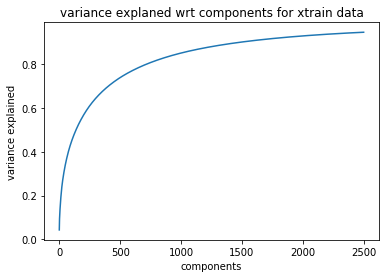

95 and 90 varaince components are 0, 1461
difference between ninety variance and ninety five variance components for xtrain data is -1461
started finding the best components for max variance on xcv data


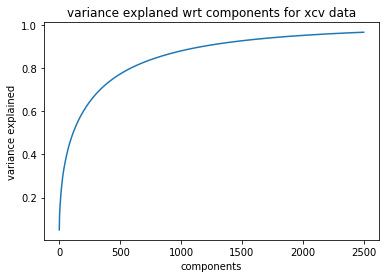

95 and 90 varaince components are 1953, 1171
difference between ninety variance and ninety five variance components for xcv data is 782
started finding the best components for max variance on xtest data


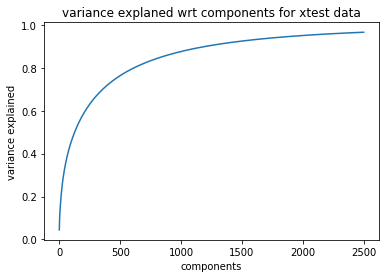

95 and 90 varaince components are 1983, 1203
difference between ninety variance and ninety five variance components for xtest data is 780
best components are [2500, 1172, 1204] for ['xtrain data', 'xcv data', 'xtest data']
setting components value to the max of best componets 2500 due to sklearn constrain
started reducing the components to 2500 using truncated svd
variance explained by svd for 2500 components on xtrain data is 0.9475618919870594
------------------------------------------------------------------


variance explained by svd for 2500 components on xcv data is 0.9663678683260851
------------------------------------------------------------------


variance explained by svd for 2500 components on xtest data is 0.9657910973787542
------------------------------------------------------------------


Wall time: 11min 58s


In [37]:
%%time
unigram_xtrain_svd_data, unigram_xcv_svd_data,unigram_xtest_svd_data  = reduce_svd_data\
(components=2500, datasets=[unigram_xtrain_vect, unigram_xcv_vect, unigram_xtest_vect], names=['xtrain data','xcv data','xtest data'])

### saving all the unigram vectors so that we can load the arrays directly when modelling 

In [38]:
np.savez('unigram_vectors.npz', unigram_xtrain_svd_data = unigram_xtrain_svd_data, unigram_xcv_svd_data=unigram_xcv_svd_data, unigram_xtest_svd_data=unigram_xtest_svd_data)

In [39]:
unigram_vectors = np.load('unigram_vectors.npz')

In [40]:
unigram_vectors.files

['unigram_xtrain_svd_data', 'unigram_xcv_svd_data', 'unigram_xtest_svd_data']

In [41]:
unigram_xtrain_svd_data.shape, unigram_xcv_svd_data.shape, unigram_xtest_svd_data.shape

((60000, 2500), (20000, 2500), (20000, 2500))

# Bi-Grams
#### converting data into vectors using bigrams technique

In [42]:
bigram_count_vect = CountVectorizer(ngram_range=(1,2))
bigram_xtrain_vect = bigram_count_vect.\
fit_transform(train_df.CleanedText)

bigram_xtest_vect = bigram_count_vect.transform(test_df.CleanedText)

bigram_xcv_vect = bigram_count_vect.transform(cv_df.CleanedText)

In [43]:
print(bigram_xtrain_vect.shape, bigram_xcv_vect.shape, bigram_xtest_vect.shape)

(60000, 812432) (20000, 812432) (20000, 812432)


In [44]:
# Lets reduce the 812432 features to 3000 using truncated svd

started finding the best components for max variance on bigrams xtrain data


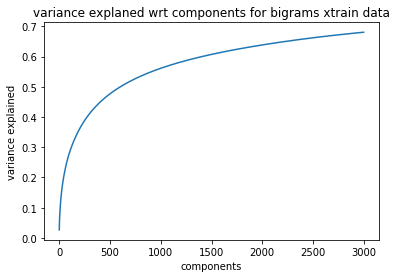

95 and 90 varaince components are 0, 0
difference between ninety variance and ninety five variance components for bigrams xtrain data is 0
started finding the best components for max variance on bigrams xcv data


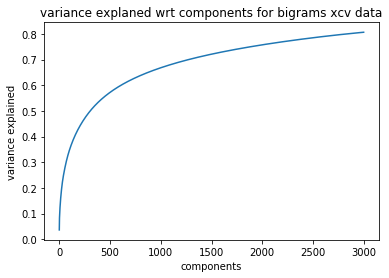

95 and 90 varaince components are 0, 0
difference between ninety variance and ninety five variance components for bigrams xcv data is 0
started finding the best components for max variance on bigrams xtest data


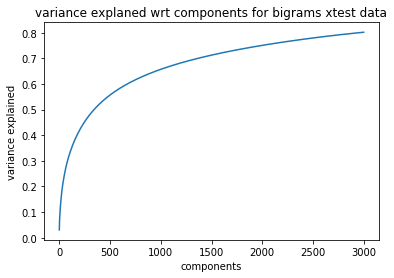

95 and 90 varaince components are 0, 0
difference between ninety variance and ninety five variance components for bigrams xtest data is 0
best components are [3000, 3000, 3000] for ['bigrams xtrain data', 'bigrams xcv data', 'bigrams xtest data']
setting components value to the max of best componets 3000 due to sklearn constrain
started reducing the components to 3000 using truncated svd
variance explained by svd for 3000 components on bigrams xtrain data is 0.6806119054397223
------------------------------------------------------------------


variance explained by svd for 3000 components on bigrams xcv data is 0.8062179870488625
------------------------------------------------------------------


variance explained by svd for 3000 components on bigrams xtest data is 0.8019617610194787
------------------------------------------------------------------


Wall time: 3h 51min 54s


In [45]:
%%time
bigram_xtrain_svd_data, bigram_xcv_svd_data, bigram_xtest_svd_data  = reduce_svd_data\
(components=3000, datasets=[bigram_xtrain_vect, bigram_xcv_vect, bigram_xtest_vect], names=['bigrams xtrain data','bigrams xcv data','bigrams xtest data'])

### saving all the bigram vectors so that we can load the arrays directly when modelling 

In [46]:
np.savez('bigram_vectors.npz', bigram_xtrain_svd_data = bigram_xtrain_svd_data, bigram_xcv_svd_data=bigram_xcv_svd_data, bigram_xtest_svd_data=bigram_xtest_svd_data)

In [47]:
bigram_vects = np.load("bigram_vectors.npz")
bigram_vects.files

['bigram_xtrain_svd_data', 'bigram_xcv_svd_data', 'bigram_xtest_svd_data']

# TF-IDF
#### converting data into vectors using bigrams technique

In [48]:
tfidf = TfidfVectorizer(ngram_range=(1,2))
tfidf_xtrain_vect = tfidf.\
fit_transform(train_df.CleanedText)

tfidf_xtest_vect = tfidf.transform(test_df.CleanedText)

tfidf_xcv_vect = tfidf.transform(cv_df.CleanedText)

In [49]:
print(tfidf_xtrain_vect.shape, tfidf_xcv_vect.shape, tfidf_xtest_vect.shape)

(60000, 812432) (20000, 812432) (20000, 812432)


#### Reducing the dimensions of tfidf_xtrain_vect andf tfidf_xtest_vect from 115865 to 1000 using truncated svd

started finding the best components for max variance on tfidf xtrain data


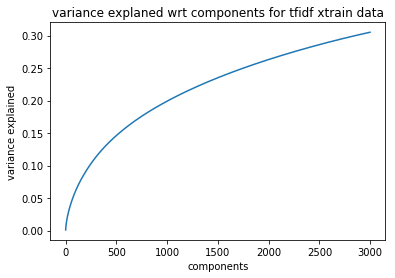

95 and 90 varaince components are 0, 0
difference between ninety variance and ninety five variance components for tfidf xtrain data is 0
started finding the best components for max variance on tfidf xcv data


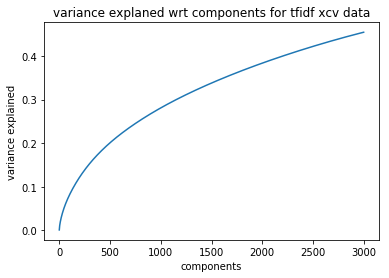

95 and 90 varaince components are 0, 0
difference between ninety variance and ninety five variance components for tfidf xcv data is 0
started finding the best components for max variance on tfidf xtest data


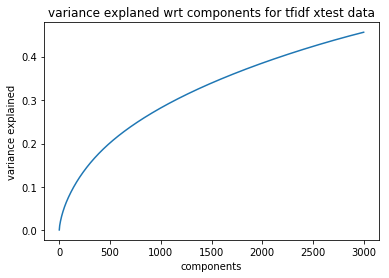

95 and 90 varaince components are 0, 0
difference between ninety variance and ninety five variance components for tfidf xtest data is 0
best components are [3000, 3000, 3000] for ['tfidf xtrain data', 'tfidf xcv data', 'tfidf xtest data']
setting components value to the max of best componets 3000 due to sklearn constrain
started reducing the components to 3000 using truncated svd
variance explained by svd for 3000 components on tfidf xtrain data is 0.3051432601320846
------------------------------------------------------------------


variance explained by svd for 3000 components on tfidf xcv data is 0.454556751867997
------------------------------------------------------------------


variance explained by svd for 3000 components on tfidf xtest data is 0.4561952647026708
------------------------------------------------------------------


Wall time: 3h 55min 22s


In [50]:
%%time
tfidf_xtrain_svd_data, tfidf_xcv_svd_data, tfidf_xtest_svd_data  = reduce_svd_data\
(components=3000, datasets=[tfidf_xtrain_vect, tfidf_xcv_vect, tfidf_xtest_vect], names=['tfidf xtrain data','tfidf xcv data','tfidf xtest data'])

### saving all the tfidf vectors so that we can load the arrays directly when modelling 

In [51]:
np.savez('tfidf_vectors.npz', tfidf_xtrain_svd_data = tfidf_xtrain_svd_data, tfidf_xcv_svd_data=tfidf_xcv_svd_data, tfidf_xtest_svd_data=tfidf_xtest_svd_data)

In [52]:
tfidf_vects = np.load("tfidf_vectors.npz")
tfidf_vects.files

['tfidf_xtrain_svd_data', 'tfidf_xcv_svd_data', 'tfidf_xtest_svd_data']

# word2vec

In [53]:
%%time
# Training our own Word2Vec model using your x_train reviews text corpus
#import gensim
x_train_list_of_words=[]
for sent in train_df.CleanedText:
    x_train_list_of_words.append(sent.split(' '))

    
print(x_train_list_of_words[0])
print('\n')
print(train_df.CleanedText[0])

['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'book', 'introduc', 'silli', 'classic', 'book', 'will', 'bet', 'son', 'still', 'abl', 'recit', 'memori', 'colleg']


witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg
Wall time: 945 ms


In [54]:
%%time
# lets apply word2vec on list_of_sent
x_train_w2v_model = gensim.models.Word2Vec(x_train_list_of_words, \
                                 min_count=5,size=50, workers=4)

Wall time: 9.36 s


In [55]:
%%time

# Training our own Word2Vec model using your x_test reviews text corpus

#import gensim
x_test_list_of_words=[]
for sent in test_df.CleanedText:
    x_test_list_of_words.append(sent.split(' '))

    
# lets apply word2vec on list_of_sent
x_test_w2v_model = gensim.models.Word2Vec(x_test_list_of_words, \
                                 min_count=5,size=50, workers=4)

Wall time: 2.49 s


In [56]:
%%time

# Training our own Word2Vec model using your x_cv reviews text corpus
#import gensim
x_cv_list_of_words=[]
for sent in cv_df.CleanedText:
    x_cv_list_of_words.append(sent.split(' '))
    
# lets apply word2vec on list_of_sent
x_cv_w2v_model = gensim.models.Word2Vec(x_cv_list_of_words, \
                                 min_count=5,size=50, workers=4)

Wall time: 3.43 s


## Average word 2 vec

In [58]:
%%time
w2v_xtrain_vect = []
for sent in x_train_list_of_words:
    sum_w2v = np.zeros(50)
    for word in sent:
        try:
            sum_w2v += x_train_w2v_model.wv[word]
        except:
            pass
    w2v_xtrain_vect.append(sum_w2v/len(sent))
    
print(len(w2v_xtrain_vect), len(w2v_xtrain_vect[0]))

60000 50
Wall time: 9.56 s


In [59]:
w2v_xtrain_vect

[array([ 0.08200232, -0.16252198,  0.07611739, -0.15404212,  0.04006883,
        -0.13708881, -0.09755405,  0.19553747, -0.01511068, -0.01347344,
        -0.52310634, -0.44557839, -0.33251569,  0.04673851, -0.23194758,
         0.23468024, -0.5314342 , -0.14688036,  0.09668012,  0.54395467,
        -0.25078835,  0.40254519, -0.22944523, -0.13541082, -0.2818813 ,
         0.29290889, -0.01949173,  0.11394467, -0.15874271, -0.05690784,
         0.22807175, -0.28805333, -0.75686509,  0.26100737, -0.16135601,
         0.34121898,  0.10602431, -0.26420998,  0.30456504,  0.26213449,
        -0.0295617 ,  0.15842135, -0.00443593,  0.31545577,  0.21849105,
        -0.29111822, -0.59870023, -0.40582371, -0.65425795, -0.11192598]),
 array([ 0.23922245, -0.64045268,  0.13719283, -0.3373983 , -0.05391583,
        -0.38252354,  0.01182077, -0.00813912, -0.22288567, -0.15480799,
        -0.77385267, -0.51844471, -0.35989008,  0.03017845, -0.51890415,
         0.62318615, -0.32166692, -0.01608787, -0

In [60]:
%%time
### converting x_test data into vectors using average word2vec
w2v_xcv_vect = []
for sent in x_cv_list_of_words:
    sum_w2v = np.zeros(50)
    for word in sent:
        try:
            sum_w2v += x_cv_w2v_model.wv[word]
        except:
            pass
    w2v_xcv_vect.append(sum_w2v/len(sent))

Wall time: 3.5 s


In [61]:
%%time
### converting x_test data into vectors using average word2vec
w2v_xtest_vect = []
for sent in x_test_list_of_words:
    sum_w2v = np.zeros(50)
    for word in sent:
        try:
            sum_w2v += x_test_w2v_model.wv[word]
        except:
            pass
    w2v_xtest_vect.append(sum_w2v/len(sent))

w2v_xtest_vect

Wall time: 3.5 s


### saving all the tfidf vectors so that we can load the arrays directly when modelling 

In [62]:
np.savez('avg_w2v_vectors.npz', w2v_xtrain_vect = w2v_xtrain_vect, w2v_xcv_vect=w2v_xcv_vect, w2v_xtest_vect=w2v_xtest_vect)

In [63]:
avg_w2v_vects = np.load("avg_w2v_vectors.npz")
avg_w2v_vects.files

['w2v_xtrain_vect', 'w2v_xcv_vect', 'w2v_xtest_vect']

# Average TF IDF W2V

In [64]:
tfidf_xtrain_features_list = tfidf.get_feature_names()
tfidf_xtest_features_list = tfidf.get_feature_names()

print(len(tfidf_xtrain_features_list),\
len(tfidf_xtest_features_list))

tfidf_xtrain_features_array = np.array(tfidf_xtrain_features_list)
tfidf_xtest_features_array = np.array(tfidf_xtest_features_list)
tfidf_xcv_features_array = tfidf_xtest_features_array

812432 812432


In [ ]:
'''x_train_features_word_position = {}

for position, word in enumerate(tfidf_xtrain_features_array):
    x_train_features_word_position[word] = position
    
x_test_features_word_position = {}

for position, word in enumerate(tfidf_xtest_features_array):
    x_test_features_word_position[word] = position
    
x_cv_features_word_position = {}

for position, word in enumerate(tfidf_xcv_features_array):
    x_cv_features_word_position[word] = position'''

In [ ]:
#x_cv_features_word_position == x_train_features_word_position

In [65]:
tfidf_features_word_position = {}

for position, word in enumerate(tfidf_xtrain_features_array):
    tfidf_features_word_position[word] = position

In [66]:
tfidf_xtrain_features_list == tfidf_xtest_features_list

True

In [67]:
(tfidf_xtrain_features_array == tfidf_xtest_features_array).sum()

812432

In [68]:
%%time 
tfidf_w2v_xtrain_vect = []
t_0 = time.time()
for row, sent in enumerate(x_train_list_of_words): #dont forget
    sum_tfidf_w2v = np.zeros(50)
    sum_tfidf = 0
    #weighted_tfidf = np.array([])
    for word in sent:
        try:
            tfidf_value = tfidf_xtrain_vect[row, \
                                            tfidf_features_word_position[word]]
            #tfidf_value = tfidf_matrix_time[row, np.where(tfidf_features_array == word)[0][0]]
            sum_tfidf += tfidf_value
            #weighted_tfidf = np.append(weighted_tfidf, tfidf_value)
            sum_tfidf_w2v += (tfidf_value * x_train_w2v_model.wv[word])
        except:
            pass
    
    tfidf_w2v_xtrain_vect.append(sum_tfidf_w2v / sum_tfidf)
    #sent_tfidf_w2v_array.append(sum_tfidf_w2v/np.sum(weighted_tfidf))
    if (row%25000)== 0:
        print('time took for {} rows is {}'.format\
              (row, str(timedelta(seconds=time.time() - t_0))))

time took for 0 rows is 0:00:00.002000
time took for 25000 rows is 0:00:35.952659
time took for 50000 rows is 0:01:14.640063
Wall time: 1min 29s


In [69]:
%%time 
tfidf_w2v_xcv_vect = []
t_0 = time.time()
for row, sent in enumerate(x_cv_list_of_words): #dont forget
    sum_tfidf_w2v = np.zeros(50)
    sum_tfidf = 0
    #weighted_tfidf = np.array([])
    for word in sent:
        try:
            tfidf_value = tfidf_xcv_vect[row, \
                                            tfidf_features_word_position[word]]
            #tfidf_value = tfidf_matrix_time[row, np.where(tfidf_features_array == word)[0][0]]
            sum_tfidf += tfidf_value
            #weighted_tfidf = np.append(weighted_tfidf, tfidf_value)
            sum_tfidf_w2v += (tfidf_value * x_cv_w2v_model.wv[word])
        except:
            pass
    
    tfidf_w2v_xcv_vect.append(sum_tfidf_w2v / sum_tfidf)
    #sent_tfidf_w2v_array.append(sum_tfidf_w2v/np.sum(weighted_tfidf))
    if (row%25000)== 0:
        print('time took for {} rows is {}'.format\
              (row, str(timedelta(seconds=time.time() - t_0))))

time took for 0 rows is 0:00:00.004004
Wall time: 27 s


In [70]:
%%time 
tfidf_w2v_xtest_vect = []
t_0 = time.time()
for row, sent in enumerate(x_test_list_of_words): #dont forget
    sum_tfidf_w2v = np.zeros(50)
    sum_tfidf = 0
    #weighted_tfidf = np.array([])
    for word in sent:
        try:
            tfidf_value = tfidf_xtest_vect[row, \
                                            tfidf_features_word_position[word]]
            #tfidf_value = tfidf_matrix_time[row, np.where(tfidf_features_array == word)[0][0]]
            sum_tfidf += tfidf_value
            #weighted_tfidf = np.append(weighted_tfidf, tfidf_value)
            sum_tfidf_w2v += (tfidf_value * x_test_w2v_model.wv[word])
        except:
            pass
    
    tfidf_w2v_xtest_vect.append(sum_tfidf_w2v / sum_tfidf)
    #sent_tfidf_w2v_array.append(sum_tfidf_w2v/np.sum(weighted_tfidf))
    if (row%25000)== 0:
        print('time took for {} rows is {}'.format\
              (row, str(timedelta(seconds=time.time() - t_0))))

time took for 0 rows is 0:00:00.003000
Wall time: 26.5 s


### saving all the averages tfidf w2v vectors so that we can load the arrays directly when modelling 

In [71]:
np.savez('tfidf_avg_w2v_vectors.npz', tfidf_w2v_xtrain_vect = tfidf_w2v_xtrain_vect, tfidf_w2v_xcv_vect=tfidf_w2v_xcv_vect, tfidf_w2v_xtest_vect=tfidf_w2v_xtest_vect)

In [72]:
tfidf_avg_w2v_vects = np.load("tfidf_avg_w2v_vectors.npz")
tfidf_avg_w2v_vects.files

['tfidf_w2v_xtrain_vect', 'tfidf_w2v_xcv_vect', 'tfidf_w2v_xtest_vect']

# conclusion

1. Assumed every review with less than 3 rating as negative review and greater than 3 as positive review and stored in a column called Score
2. Performed Data wrangling on amazon finefood reviews dataset by removing duplicate reviews and duplicate productid's'
3. Took first one lakh data points after datawrangling and sorted the data by time
4. Split the first one lakh datapoint into train validation and test datasets
5. Converted each review as vectors using techniques like Bag Of Words, Unigram Bigram, TFIDF, average word 2 vec, and TFIDF word 2 vec and done exploratory data analysis 
6. Reduced the dimensions of vectors which are obtained from Bag of words, TFIDF, average word 2 vec and TFIDF word2vec using Truncated SVD 

# see the next notebook for knn model